In [1]:
import numpy as np
import pandas as pd
import pylab as pl
from matplotlib.dates import MonthLocator, YearLocator
from sklearn import tree
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

filename_test = 'test.csv'
filename_train = 'train.csv'
filename_store = 'store.csv'

train = pd.read_csv(filename_train, header=0, low_memory=False)

test = pd.read_csv(filename_test, header=0, low_memory=False)


store_info = pd.read_csv(filename_store, header=0, low_memory=False)

train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

def print_missing_stats():
    for data_name, data in {'TRAIN': train, 'TEST': test, 'STORE': store_info}.items():
        print(data_name, ' (overall = %d)' % len(data))
        for attribute in data.columns:
            mask = data[attribute].isnull()
            k = len(data[attribute][mask].tolist())
            print('%5d (%2d%%)' % (k, 100*k/len(data)), 'missing values in ', attribute) 
        print()
# print_missing_stats()

### Filling missing values

In [2]:
# print(test[test.Open.isnull()])
test.ix[test.Open.isnull(), 'Open'] = 1

store_info.ix[store_info.CompetitionDistance.isnull(),
         'CompetitionDistance'] = 0
store_info.ix[store_info.CompetitionOpenSinceMonth.isnull(),
         'CompetitionOpenSinceMonth'] = 0
store_info.ix[store_info.CompetitionOpenSinceYear.isnull(),
         'CompetitionOpenSinceYear'] = 0
store_info.ix[store_info.Promo2SinceWeek.isnull(),
         'Promo2SinceWeek'] = 0
store_info.ix[store_info.Promo2SinceYear.isnull(),
         'Promo2SinceYear'] = 0

promo_intervals = [np.NaN] + list(store_info.PromoInterval.value_counts().index)
store_info.PromoInterval = store_info.PromoInterval.map(lambda x: promo_intervals.index(x))
# print_missing_stats()
del promo_intervals

### Constructing train data

In [3]:
date_range_train = pd.date_range('2013-01-01', '2015-06-13')
date_range_test = pd.date_range('2015-06-14', '2015-07-31')

# date_range_train = pd.date_range('2013-01-01', '2014-07-31').union(pd.date_range('2014-09-18', '2015-07-31'))
# date_range_test = pd.date_range('2014-08-01', '2014-09-17')

train = train[train.Open == 1]
train = pd.merge(train, store_info[['Store', 'CompetitionDistance']], how='left', on='Store')
validation = True
if validation:
    train_date_range = train[train.Date.isin(date_range_train)]
else:
    train_date_range = train
#     date_range_test = pd.date_range('2015-08-01', '2015-09-17')

    
train_date_range['NumberDay'] = train_date_range.Date.map(lambda d:
                                                       ((d - pd.datetime(2013, 1, 1))
                                                        /np.timedelta64(1, 'D')).astype(int))
groupby_features = ['Store', 'DayOfWeek', 'Promo', 'CompetitionDistance']

/home/oem/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


RMSPE = 0.128633997148


/home/oem/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


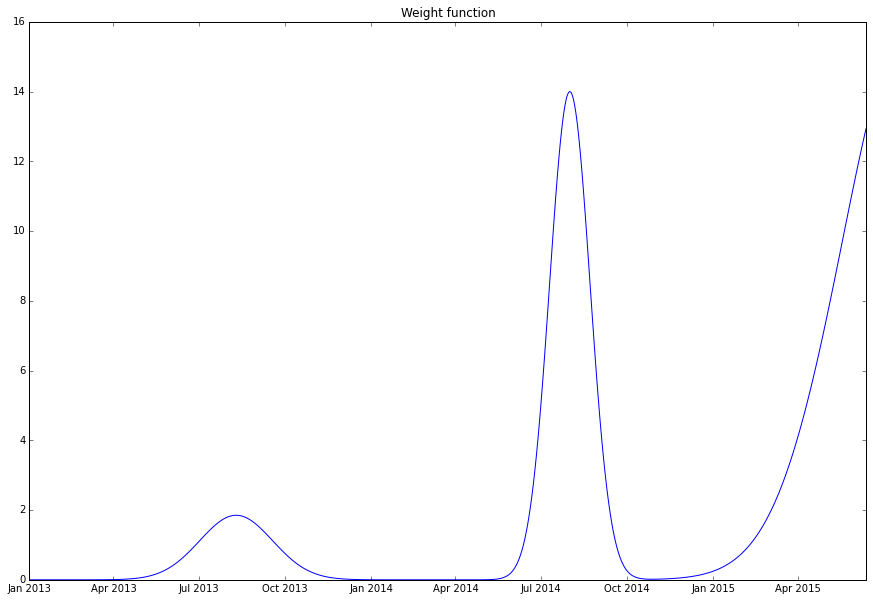

In [5]:
def custom_aggregate(group):
    weights = group['Weight']
    sales = group['Sales']
    return np.sum(np.array(weights) * np.array(sales)) / (np.sum(weights))

def compute_RMSPE(test_labels, predicted_labels):
    mask = test_labels.nonzero()
    y = test_labels[mask]
    y_hat = predicted_labels[mask]
    return np.sqrt(np.mean(((y - y_hat)/y)**2))

alphas, rmspe_s = [], []
min_alpha, min_rmspe = 0., 1.

grid_space = [10]
for alpha in grid_space:
    
    def weight_function(x):
        return 1.85*np.exp(-(x - 221)**2/55**2) + 14*np.exp(-(x - 577)**2/30.5**2) + 16.05*np.exp(-(x - 941)**2/103.3**2)
    
    train_date_range['Weight'] = train_date_range.NumberDay.map(weight_function)
    if len(grid_space) <= 1:
        pl.figure(figsize=(15,10))
        pl.title('Weight function')
#         pl.plot(train_date_range['Date'], train_date_range['NumberDay'], 'k--')
        pl.plot(train_date_range['Date'], train_date_range['Weight'], 'b-')
    else:
        print('trying alpha =', alpha, end='\t')
    grouped = train_date_range.groupby(groupby_features, as_index=False)
    sales_predicted = pd.DataFrame(grouped.apply(custom_aggregate), columns=['PredictedSales']).reset_index()

    if not validation and len(grid_space) <= 1:
        test = pd.merge(test, store_info[['Store', 'CompetitionDistance']], on='Store', how='left')
        df = pd.merge(test, sales_predicted, how='left', on=groupby_features)
        df.ix[df.Open == 0, 'PredictedSales'] = 0
        df.rename(columns={'PredictedSales': 'Sales'}, inplace=True)
        df[['Id', 'Sales']].to_csv('prediction_simple.csv', index=False)
        print('\nResult was written to prediction_simple.csv')
    else:
        local_test = train[train.Date.isin(date_range_test)]
        df = pd.merge(local_test, sales_predicted, how='left', on=groupby_features)
        df.ix[df.Open == 0, 'PredictedSales'] = 0
        loss_score = compute_RMSPE(np.array(df['Sales']), np.array(df['PredictedSales']))
        print('RMSPE =', loss_score)
        if loss_score <= min_rmspe:
            min_rmspe = loss_score
            min_alpha = alpha
        alphas.append(alpha)
        rmspe_s.append(loss_score)
        
    del sales_predicted, grouped, df

if len(grid_space) > 1:
    pl.figure(figsize=(15,10))
    pl.title('grid space')
    print('Min alpha =', min_alpha, 'Min RMSPE =', min_rmspe)
    pl.plot(alphas, rmspe_s, 'r.--')